<a href="https://colab.research.google.com/github/jithamanyu001/CV/blob/main/DEEPDREAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DeepDream**

Using a trained CNN network to search for patterns and amplify those patterns that are appearnt in that image. 

We feed in an input image. Then we choose a layer from that network and ask the network to amplify what was detected. 

Depending on the layer that has been chosen differnt parts get amplified. Coz some layers detect higher level features some detect lower level features. 

We use a pretrained network such as VGG to extract features. Then calculate loss which is sum of actication between the chosen layers. We then also normalise it so as to makke contributions equal and also occur at differnt granularity. 

Them image as the variable we maximise the loss.

**This is a keras implementation**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19,inception_v3

In [ ]:
model=inception_v3.InceptionV3(False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
outputs={
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

In [ ]:
output_dict=dict(
    [
        (layer.name,layer.output)
        for layer in [model.get_layer(name) for name in outputs.keys()]
    ]
)
features=tf.keras.Model(inputs=model.inputs,outputs=output_dict)

In [ ]:
features.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [ ]:
def calc_loss(img):
  feats=features(img)
  loss=tf.zeros(shape=())
  for i in feats:
    scaling=tf.reduce_prod(tf.cast(tf.shape(feats[i]),"float32"))
    loss += outputs[i]*tf.reduce_sum(tf.square(feats[i])) / scaling
  return loss

In [ ]:
@tf.function
def grad_ascent(img,lr):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss=calc_loss(img)
  grads=tape.gradient(loss,img)
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += lr*grads
  print(f"Loss = {loss}")
  return loss,img

def grad_ascent_loop(img,iters,lr,max_loss=None):
  for i in range(iters):
    loss,img=grad_ascent(img,lr)
    if loss>max_loss:
      break
    print("... Loss value at step %d: %.2f" % (i, loss))
  return img

In [ ]:
base_image_path = tf.keras.utils.get_file("castara-tobago.jpeg", "https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg")


In [ ]:
def preprocess_image(image_path):
    '''Util function to open, resize and format pictures
     into appropriate arrays.'''
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img
img=preprocess_image(base_image_path)
img.shape
img

array([[[[-0.4352941 , -0.02745098,  0.56078434],
         [-0.4352941 , -0.02745098,  0.56078434],
         [-0.4352941 , -0.02745098,  0.56078434],
         ...,
         [-0.5529412 , -0.04313725,  0.6       ],
         [-0.5529412 , -0.04313725,  0.6       ],
         [-0.5529412 , -0.04313725,  0.6       ]],

        [[-0.4352941 , -0.02745098,  0.56078434],
         [-0.42745095, -0.01960784,  0.5686275 ],
         [-0.42745095, -0.01960784,  0.5686275 ],
         ...,
         [-0.5529412 , -0.04313725,  0.6       ],
         [-0.5529412 , -0.04313725,  0.6       ],
         [-0.5529412 , -0.04313725,  0.6       ]],

        [[-0.41960782, -0.01176471,  0.5764706 ],
         [-0.41960782, -0.01176471,  0.5764706 ],
         [-0.41960782, -0.01176471,  0.5764706 ],
         ...,
         [-0.54509807, -0.03529412,  0.60784316],
         [-0.5529412 , -0.04313725,  0.6       ],
         [-0.5529412 , -0.04313725,  0.6       ]],

        ...,

        [[-0.92941177, -0.94509804, -0

In [ ]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
num_octave = 3  
octave_scale = 1.4
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = grad_ascent_loop(
        img, 20, 0.01, 15.0
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

Processing octave 0 with shape (816, 612)
Loss = Tensor("add_3:0", shape=(), dtype=float32)
... Loss value at step 0: 0.84
... Loss value at step 1: 0.95
... Loss value at step 2: 1.18
... Loss value at step 3: 1.46
... Loss value at step 4: 1.77
... Loss value at step 5: 2.03
... Loss value at step 6: 2.35
... Loss value at step 7: 2.65
... Loss value at step 8: 2.92
... Loss value at step 9: 3.20
... Loss value at step 10: 3.45
... Loss value at step 11: 3.76
... Loss value at step 12: 4.03
... Loss value at step 13: 4.37
... Loss value at step 14: 4.70
... Loss value at step 15: 4.99
... Loss value at step 16: 5.26
... Loss value at step 17: 5.55
... Loss value at step 18: 5.83
... Loss value at step 19: 6.23
Processing octave 1 with shape (1142, 857)
Loss = Tensor("add_3:0", shape=(), dtype=float32)
... Loss value at step 0: 1.26
... Loss value at step 1: 1.86
... Loss value at step 2: 2.29
... Loss value at step 3: 2.69
... Loss value at step 4: 3.21
... Loss value at step 5: 3.57

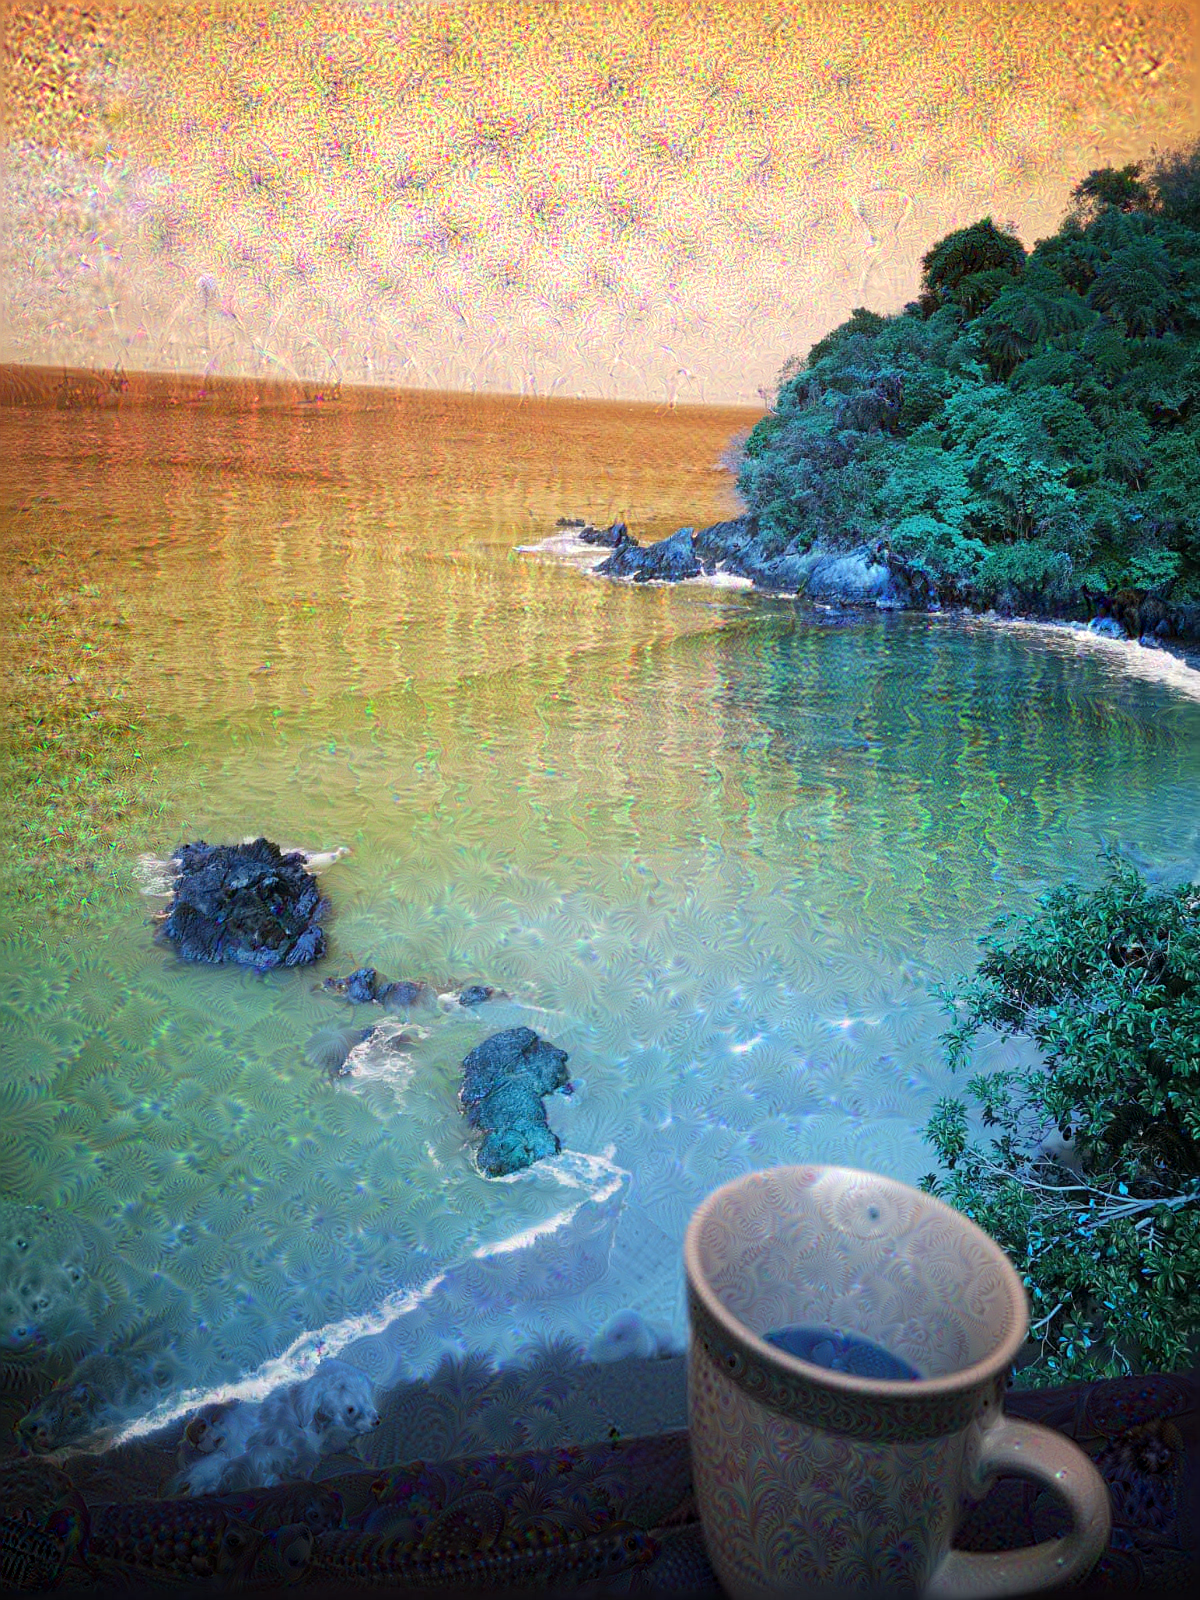

In [ ]:
from google.colab.patches import cv2_imshow
def deprocess_image(x):
    '''Util function to convert a NumPy array into a valid image.'''
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x
cv2_imshow(deprocess_image(np.array(img)))